<a href="https://colab.research.google.com/github/a-mironov/datascience-module2/blob/main/module2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Import

In [1]:
# setup / necessary imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings

from IPython.display import set_matplotlib_formats
warnings.filterwarnings('ignore')
%matplotlib inline
set_matplotlib_formats('png')

# custom exception for dummy variable creation method
class CategoryNotFoundException(Exception):
  pass

reading the dataset

In [2]:
# read dataset

path_to_dataset = './drive/MyDrive/DATASCIENCE/DATA/bank-additional-full.csv'
try:
  df_1 = pd.read_csv(path_to_dataset, sep=';', on_bad_lines = 'error')
except FileNotFoundError:
  print("File not found!")
# except ParserError:
#   print("Failed to parse lines")
else:
  print("File found and parsed.")


File found and parsed.


# Data Introduction

In [3]:
df_1.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

lots of variables here, so let's sort the categorical from the numerical.

In [4]:
vars_numerical = df_1.select_dtypes('number').columns
vars_categorical = df_1.select_dtypes(np.object).columns

vars_numerical

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

# Univariate Analysis

We plot the distributions of all numerical variables and examine their features, such as skewness (if any) and normality.

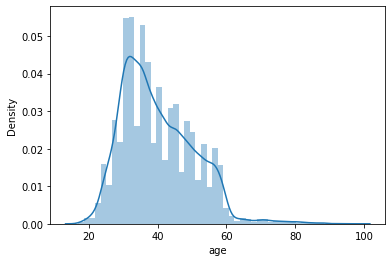

In [5]:
sns.distplot(df_1['age'])

The age distribution curve has odd peaks at several different ages. Its overall shape could be reflective of the population pyramid of the country (or countries) the bank clients are from, if such data was available.

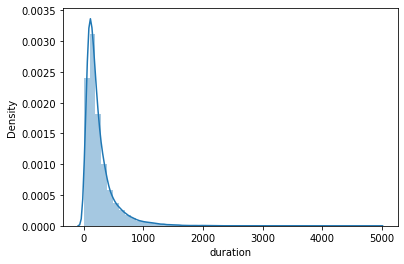

In [ ]:
sns.distplot(df_1['duration'])

The distribution is positively skewed and unimodal. Let's plot the logarithm, filtering out 0-values (of which there are a small but nonzero amount) to see if the distribution is lognormal.

There are 4 records with duration = 0.


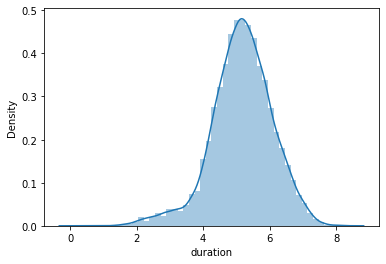

In [15]:
duration_zero_count = df_1[df_1['duration']==0].index.size
print(f"There are {duration_zero_count} records with duration = 0.")
sns.distplot(np.log(df_1[df_1['duration']!=0]['duration']))

The distribution of $\log(\text{duration})$ is fairly close to normal, except for a fatter left tail.

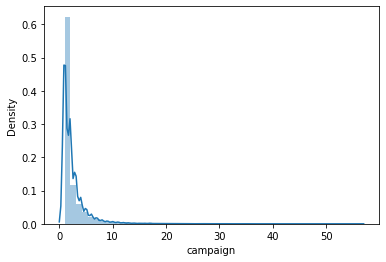

In [ ]:
sns.distplot(df_1['campaign'])

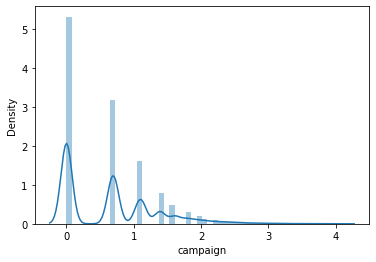

In [7]:
sns.distplot(np.log(df_1['campaign']))

An overwhelming majority of clients have only been contacted once per campaign. The density appears to decay more or less exponentially.

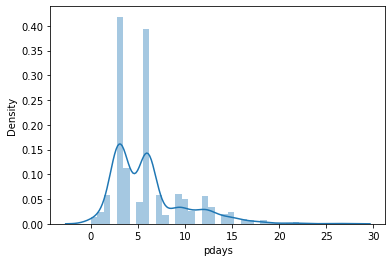

In [ ]:
# from bank-additional-names.txt:
# pdays = 999 means no previous contact
sns.distplot(df_1[df_1['pdays']!=999]['pdays'])

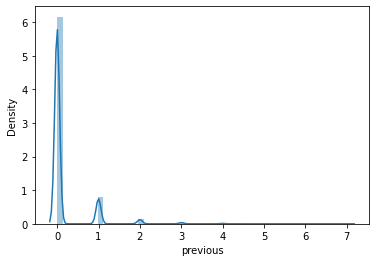

In [6]:
sns.distplot(df_1['previous'])

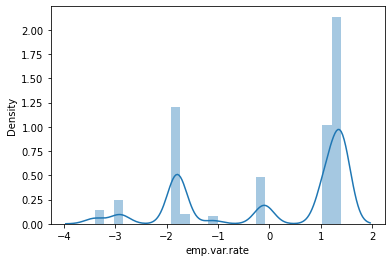

In [9]:
sns.distplot(df_1['emp.var.rate'])

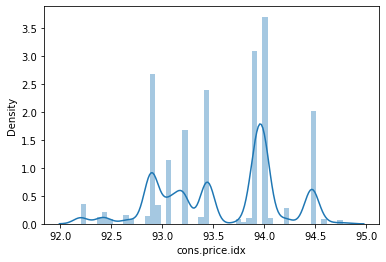

In [10]:
sns.distplot(df_1['cons.price.idx'])

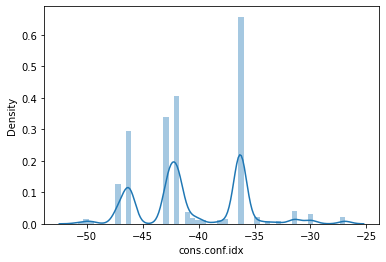

In [11]:
sns.distplot(df_1['cons.conf.idx'])

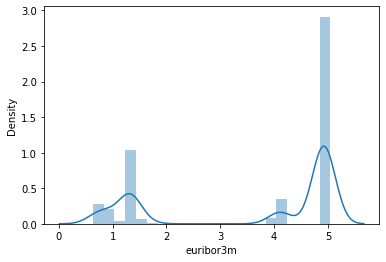

In [12]:
sns.distplot(df_1['euribor3m'])

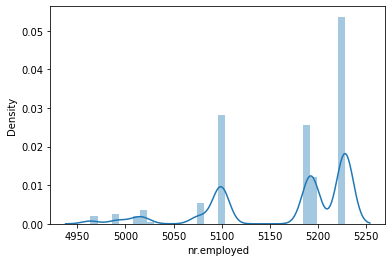

In [13]:
sns.distplot(df_1['nr.employed'])

# Bivariate Analysis

Below is the correlogram of all numerical variables in the dataset.

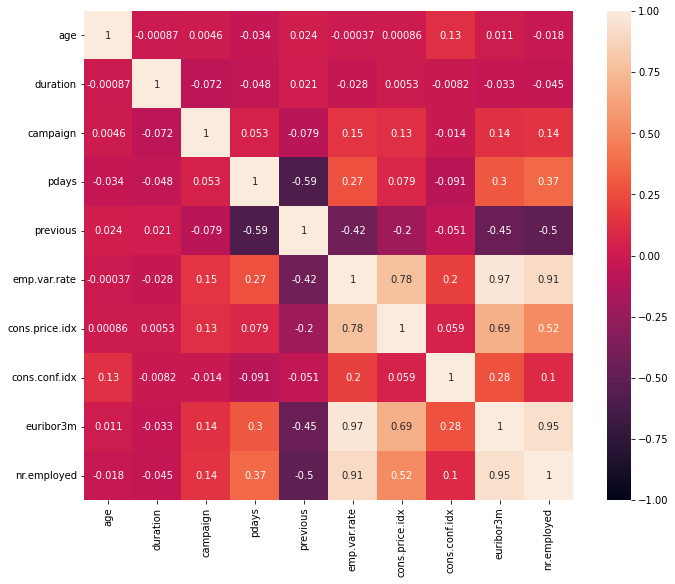

In [4]:
correl = df_1.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(correl, vmin = -1, square=True, annot=True);

Some highly correlated pairs of variables are immediately apparent:

`emp.var.rate` ~ `euribor3m` ~ `nr.employed`.

There are also some weaker correlations:

`cons.price.idx` ~ `euribor3m`, `cons.price.idx` ~ `emp.var.rate`; <br> `previous` ~ `-pdays`.

To avoid multicollinearity in a linear model, the first trio of correlated variables should be reduced to only one; excluding one of `previous` and `pdays` should also be considered.

We now look at the correlations between categorical variables using Pearson's $\chi^2$ test.

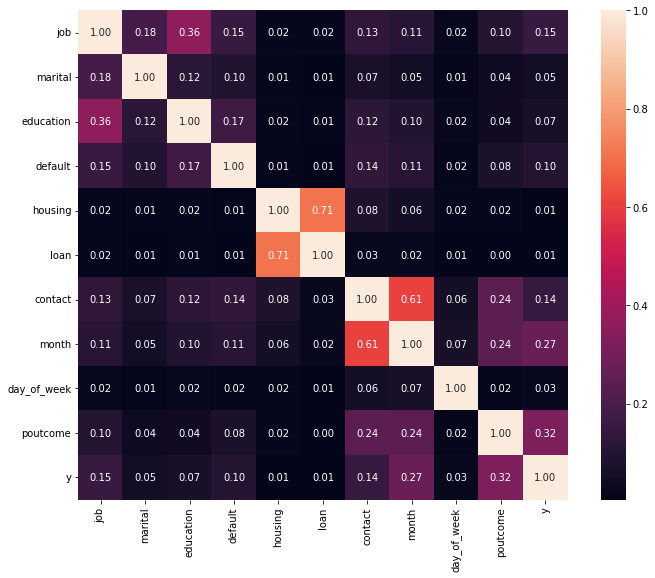

In [12]:
vars_categorical = df_1.select_dtypes(np.object).columns

categorical_corr = pd.DataFrame(index = vars_categorical, columns = vars_categorical)

for var1 in vars_categorical:
  for var2 in vars_categorical:
    crosstab_v1v2 = pd.crosstab(df_1[var1], df_1[var2])
    chi2, _, _, _ = stats.chi2_contingency(crosstab_v1v2)
    n = crosstab_v1v2.sum().sum()
    min_dim = min(crosstab_v1v2.shape) - 1 

    cramer_V = np.sqrt((chi2/n)/min_dim)
    categorical_corr.loc[var1, var2] = cramer_V

categorical_corr = categorical_corr.astype('float')

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(categorical_corr, annot = True, fmt = "1.2f", square = True)

Immediately visible are strong correlations between `housing` and `loan`, as well as between `contact` and `month`, the latter of which is somewhat peculiar. There is also a weaker correlation between `job` and `education`; however, this correlation is able to be explained based on the source of the data set.